In [1]:
import os
from pprint import pprint
from six import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
from tqdm import tqdm

In [2]:
def format_prediction_string(image_id, result):
    prediction_strings = []
    
    for i in range(len(result['detection_scores'])):
        class_name = result['detection_class_names'][i].decode("utf-8")
        YMin,XMin,YMax,XMax = result['detection_boxes'][i]
        score = result['detection_scores'][i]
        
        prediction_strings.append(
            f"{class_name} {score} {XMin} {YMin} {XMax} {YMax}"
        )
        
    prediction_string = " ".join(prediction_strings)

    return {
        "ImageID": image_id,
        "PredictionString": prediction_string
    }

In [3]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image)

In [4]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

In [5]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
            25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [6]:
sample_image_path = "../input/test/6beb79b52308112d.jpg"

with tf.Graph().as_default():
    # Create our inference graph
    image_string_placeholder = tf.placeholder(tf.string)
    decoded_image = tf.image.decode_jpeg(image_string_placeholder)
    decoded_image_float = tf.image.convert_image_dtype(
        image=decoded_image, dtype=tf.float32
    )
    # Expanding image from (height, width, 3) to (1, height, width, 3)
    image_tensor = tf.expand_dims(decoded_image_float, 0)

    # Load the model from tfhub.dev, and create a detector_output tensor
    model_url = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
    detector = hub.Module(model_url)
    detector_output = detector(image_tensor, as_dict=True)
    
    # Initialize the Session
    init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]
    sess = tf.Session()
    sess.run(init_ops)

    # Load our sample image into a binary string
    with tf.gfile.Open(sample_image_path, "rb") as binfile:
        image_string = binfile.read()

    # Run the graph we just created
    result_out, image_out = sess.run(
        [detector_output, decoded_image],
        feed_dict={image_string_placeholder: image_string}
    )

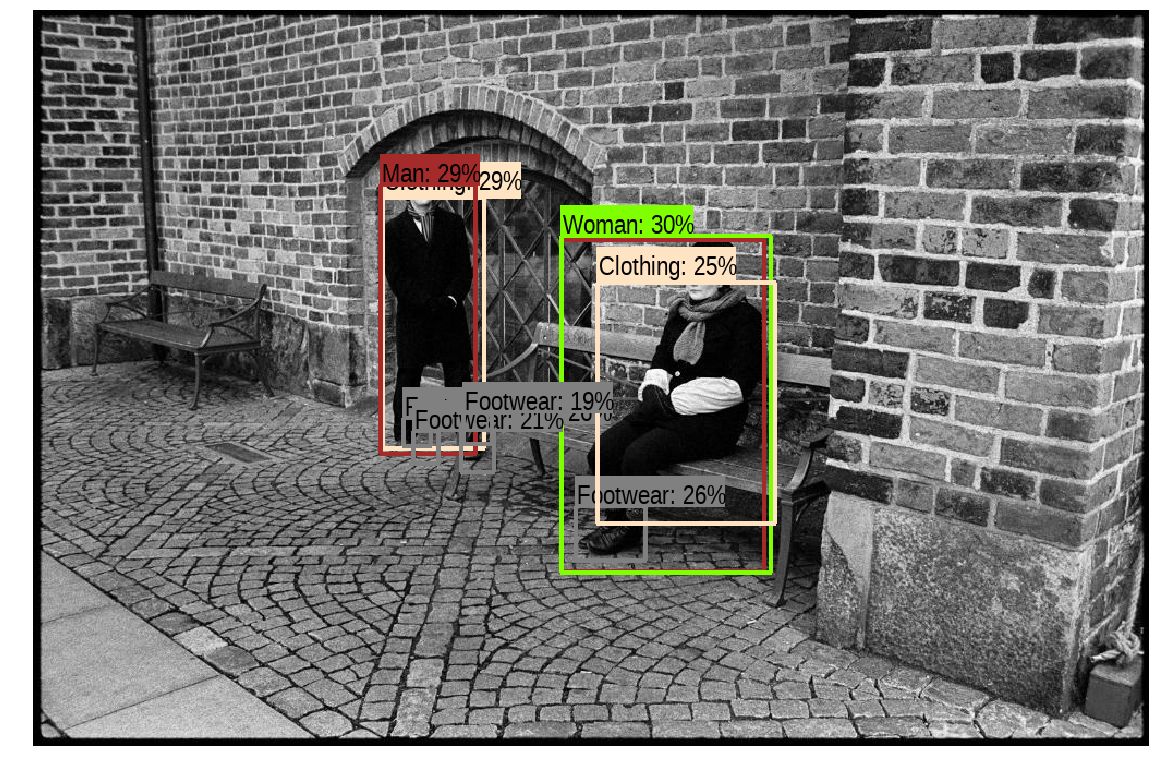

In [7]:
image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"]
)
display_image(image_with_boxes)

In [8]:
print(image_string_placeholder)
print(decoded_image)
print(decoded_image_float)
print(image_tensor)

Tensor("Placeholder:0", dtype=string)
Tensor("DecodeJpeg:0", shape=(?, ?, ?), dtype=uint8)
Tensor("convert_image:0", shape=(?, ?, ?), dtype=float32)
Tensor("ExpandDims:0", shape=(1, ?, ?, ?), dtype=float32)


In [9]:
pprint(detector_output)

{'detection_boxes': <tf.Tensor 'module_apply_default/hub_input/strided_slice:0' shape=(?, 4) dtype=float32>,
 'detection_class_entities': <tf.Tensor 'module_apply_default/hub_input/index_to_string_Lookup:0' shape=(?, 1) dtype=string>,
 'detection_class_labels': <tf.Tensor 'module_apply_default/hub_input/strided_slice_2:0' shape=(?, 1) dtype=int64>,
 'detection_class_names': <tf.Tensor 'module_apply_default/hub_input/index_to_string_1_Lookup:0' shape=(?, 1) dtype=string>,
 'detection_scores': <tf.Tensor 'module_apply_default/hub_input/strided_slice_1:0' shape=(?, 1) dtype=float32>}


In [10]:
print("result_out keys:", result_out.keys())
print("First 10 detection scores:", result_out['detection_scores'][:10])
print()
print("Shape of image_out", image_out.shape)
print("Type of image_out:", type(image_out))

result_out keys: dict_keys(['detection_class_names', 'detection_boxes', 'detection_scores', 'detection_class_labels', 'detection_class_entities'])
First 10 detection scores: [0.44731757 0.3066623  0.2993617  0.29484594 0.2944455  0.26538676
 0.26137477 0.25098038 0.21500438 0.19897702]

Shape of image_out (675, 1024, 3)
Type of image_out: <class 'numpy.ndarray'>


# Inference on Test Set

In [11]:
sample_submission_df = pd.read_csv('../input/sample_submission.csv')
image_ids = sample_submission_df['ImageId']
predictions = []

for image_id in tqdm(image_ids):
    # Load the image string
    image_path = f'../input/test/{image_id}.jpg'
    with tf.gfile.Open(image_path, "rb") as binfile:
        image_string = binfile.read()
    
    # Run our session
    result_out = sess.run(
        detector_output,
        feed_dict={image_string_placeholder: image_string}
    )
    predictions.append(format_prediction_string(image_id, result_out))

sess.close()

 16%|█▌        | 15960/99999 [57:29<4:58:29,  4.69it/s]

Note above that `fetches` is not `[detector_output, decoded_image]` anymore, but instead only `detector_output`, since we are not interested in seeing what `decoded_image`/`image_out` contain anymore. `sess.run` accepts both as input a list of tensors, or a single tensor.

You can also notice that we are safely closing our `sess`, now that we have process all the images.

# Submission

In [12]:
pred_df = pd.DataFrame(predictions)
pred_df.head()

,ImageID,PredictionString
0,b5d912e06f74e948,/m/01g317 0.4590815007686615 0.836832880973815...
1,be137cf6bb0b62d5,/m/0hg7b 0.47553807497024536 0.330710232257843...
2,8d65ca08cb5ce8e8,/m/050k8 0.4399101734161377 0.0 0.056079953908...
3,4d3ad1e52ad8c065,/m/07j7r 0.3631950616836548 0.6233987212181091...
4,9b94408691c7d7bf,/m/07xyvk 0.14220017194747925 0.01938161253929...


In [13]:
pred_df.to_csv('submission.csv', index=False)